# **Difference between pharmacologically induced EBs and genetically induced EBs**

I want to see the differences between 2 types of induction.

In [174]:
import scanpy as sc
import anndata as ad
import pandas as pd
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [175]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white', fontsize=12)

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


**Read the objects**

In [176]:
adata = ad.read_h5ad('Processing/comp_EB/Objects/object_7_Vrij_filtered_1_8_Schu_filtered_1.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 3082 × 32673
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes'


**Normalize and find highly variable genes**

In [177]:
# Data normalization
sc.pp.normalize_total(adata, target_sum=1e4)
# Log on datas
sc.pp.log1p(adata)
# Stock data logs 
adata.raw = adata
# Scale the data
sc.pp.scale(adata)
# Highly variable genes
sc.pp.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
extracting highly variable genes


C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\_utils\__init__.py:551: RuntimeWarning: overflow encountered in multiply
  return x * y


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


**Run PCA and find neighbors**

In [178]:
# Run PCA
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:01)


In [179]:
# Find neighbors
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20)
# Make groups
sc.tl.louvain(adata, resolution=0.8)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


**Plot UMAP without harmony**

In [180]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


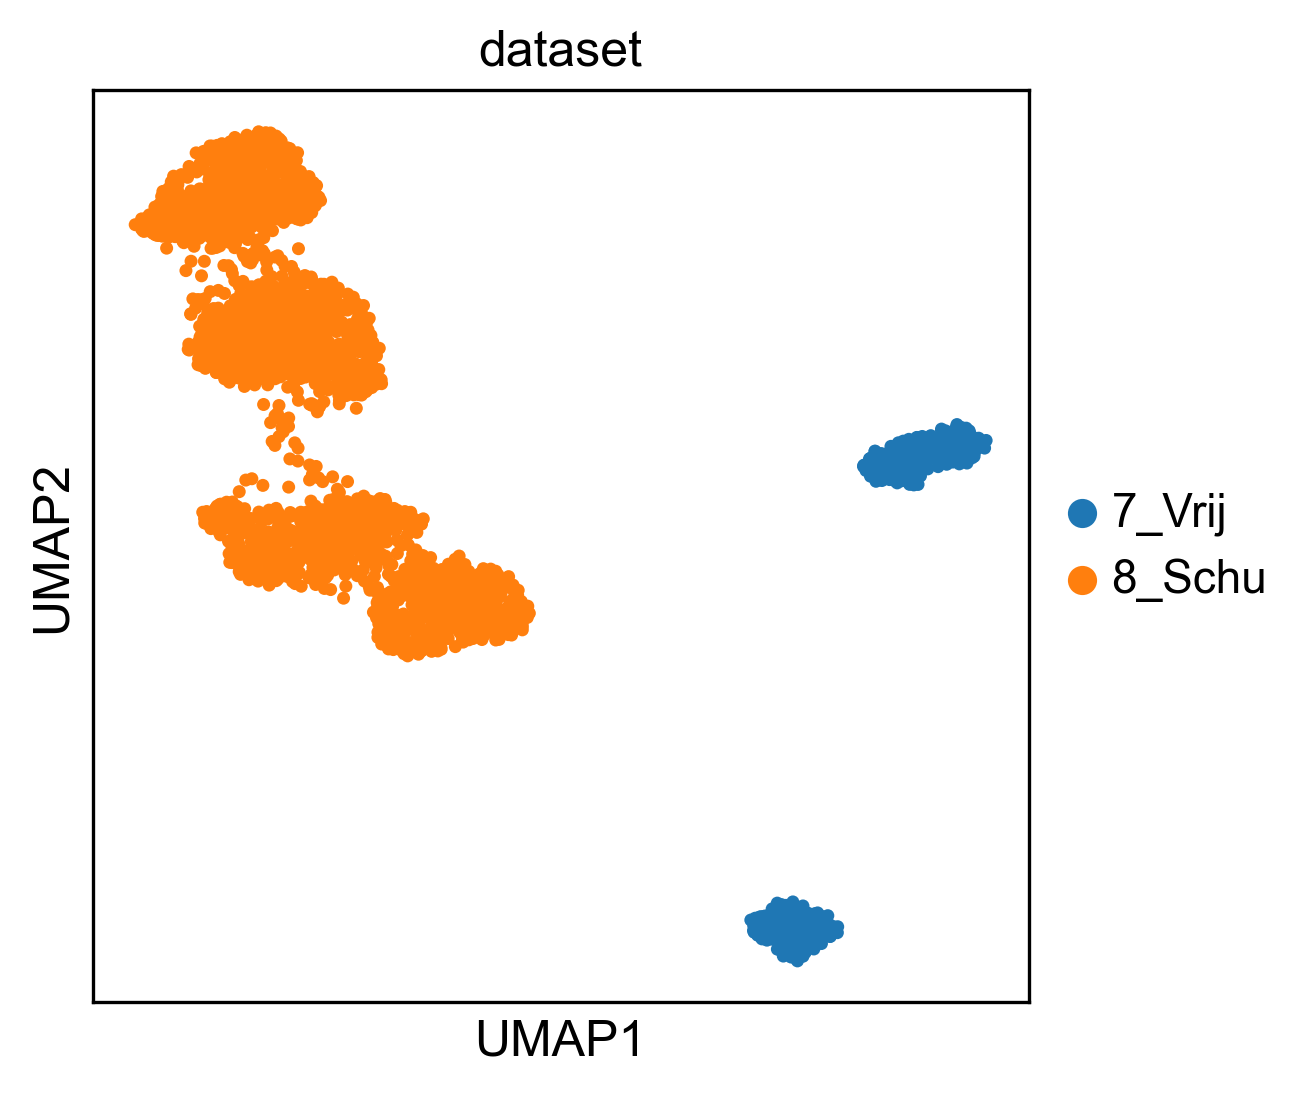

In [181]:
sc.pl.umap(adata, color='dataset')

We see that the 2 datasets don't group together, so we need to run harmony 

**Run harmony and find neighbors**

In [182]:
sc.external.pp.harmony_integrate(adata, 'dataset', theta = 1, max_iter_harmony = 10, nclust = 3)
# Save new PCA
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

2024-07-10 11:58:26,739 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-10 11:58:27,805 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-10 11:58:27,815 - harmonypy - INFO - Iteration 1 of 10
2024-07-10 11:58:27,876 - harmonypy - INFO - Iteration 2 of 10
2024-07-10 11:58:28,037 - harmonypy - INFO - Iteration 3 of 10
2024-07-10 11:58:28,168 - harmonypy - INFO - Iteration 4 of 10
2024-07-10 11:58:28,269 - harmonypy - INFO - Converged after 4 iterations


In [183]:
# Find neighbors
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)
# Make groups
sc.tl.louvain(adata, resolution=0.8)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


**Plot UMAPs**

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


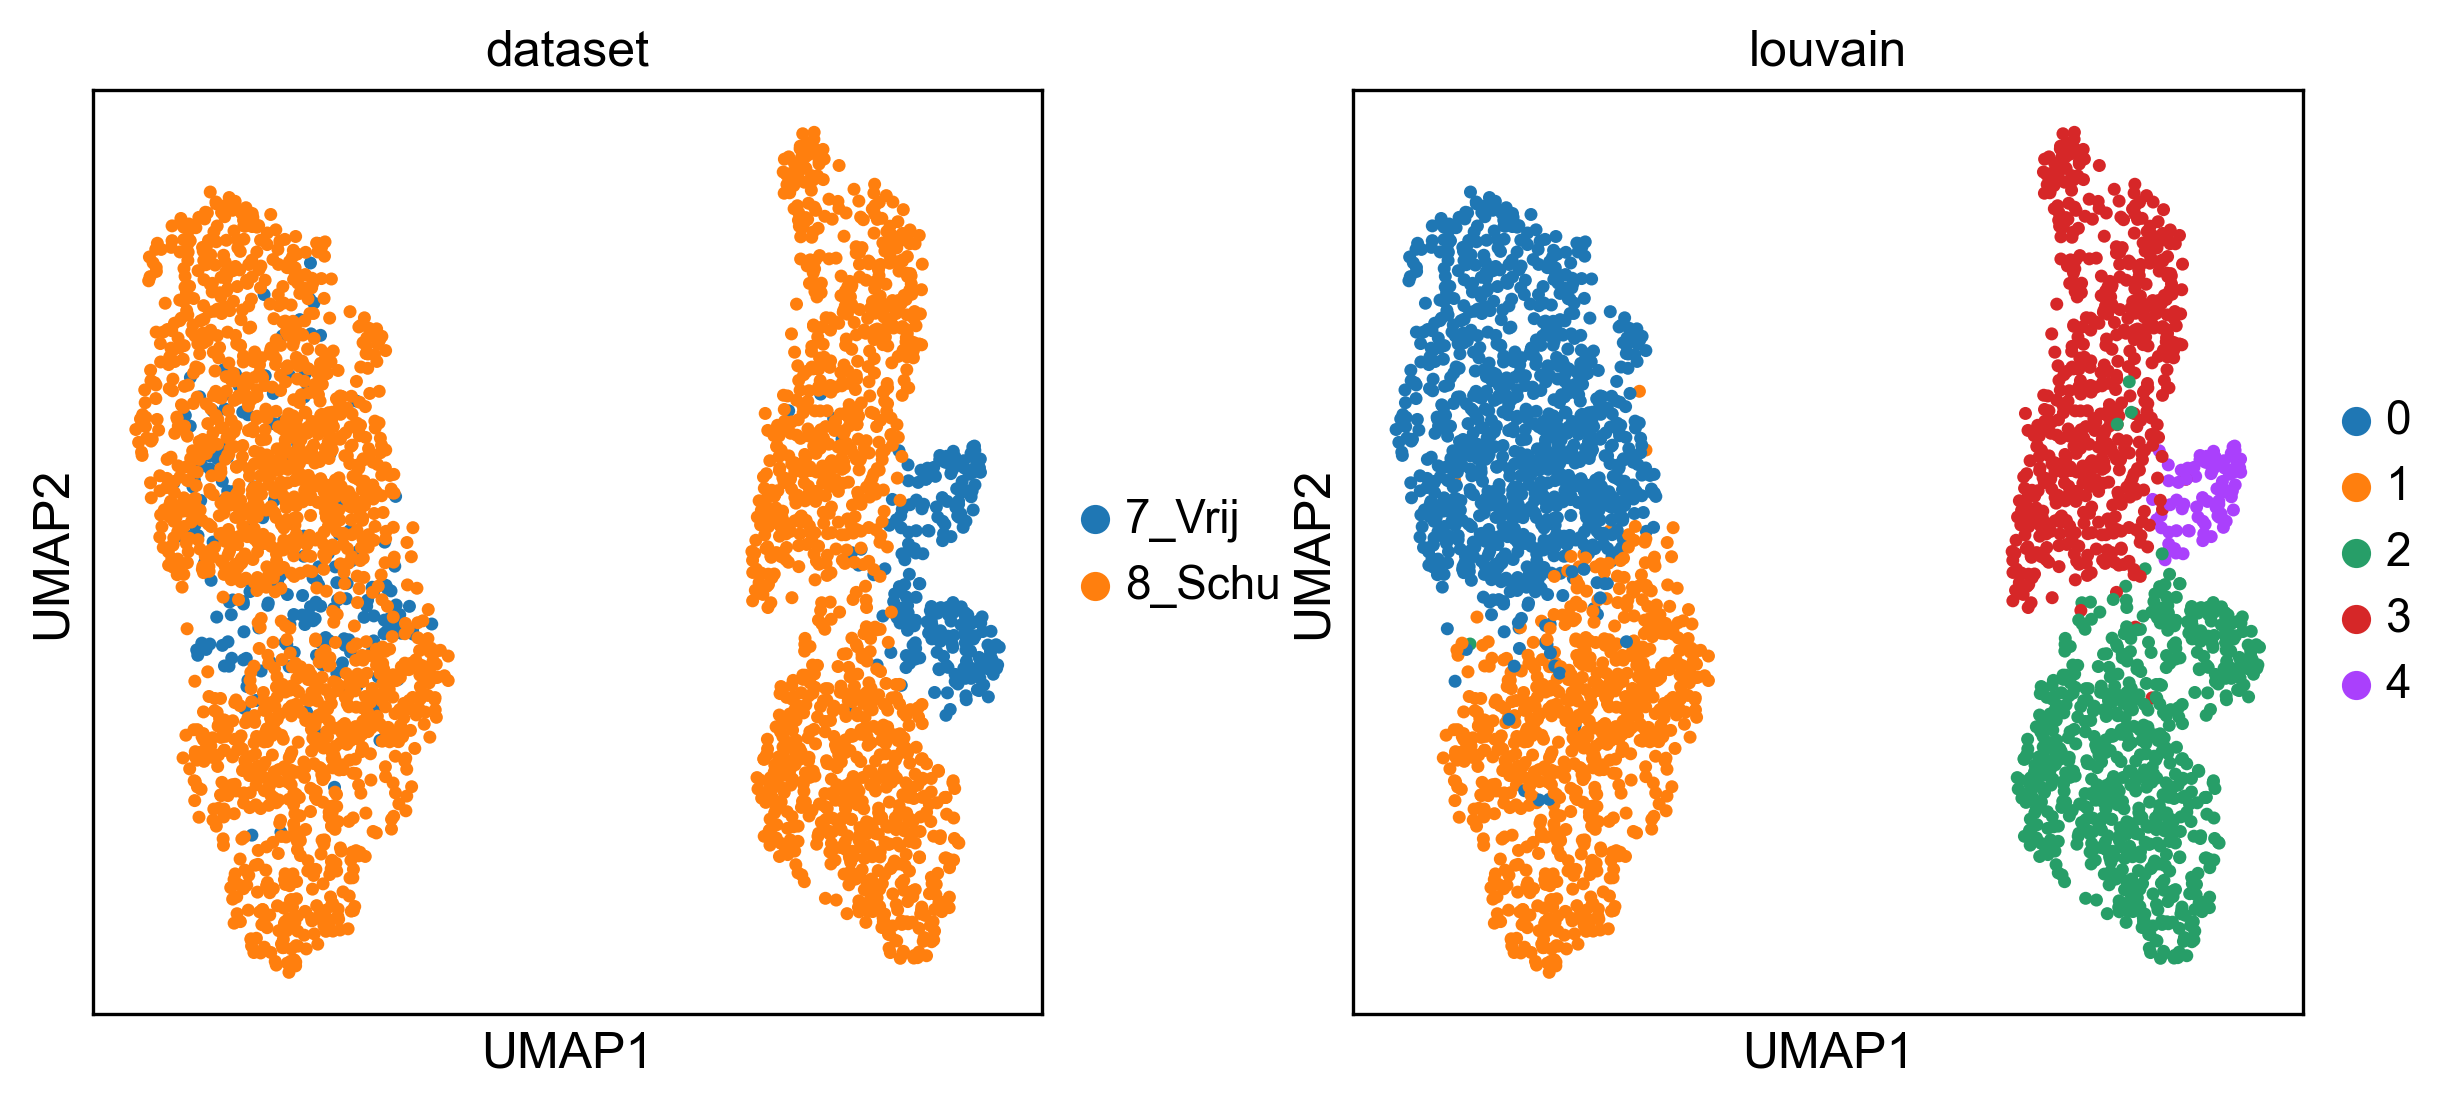

In [184]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['dataset', 'louvain'])

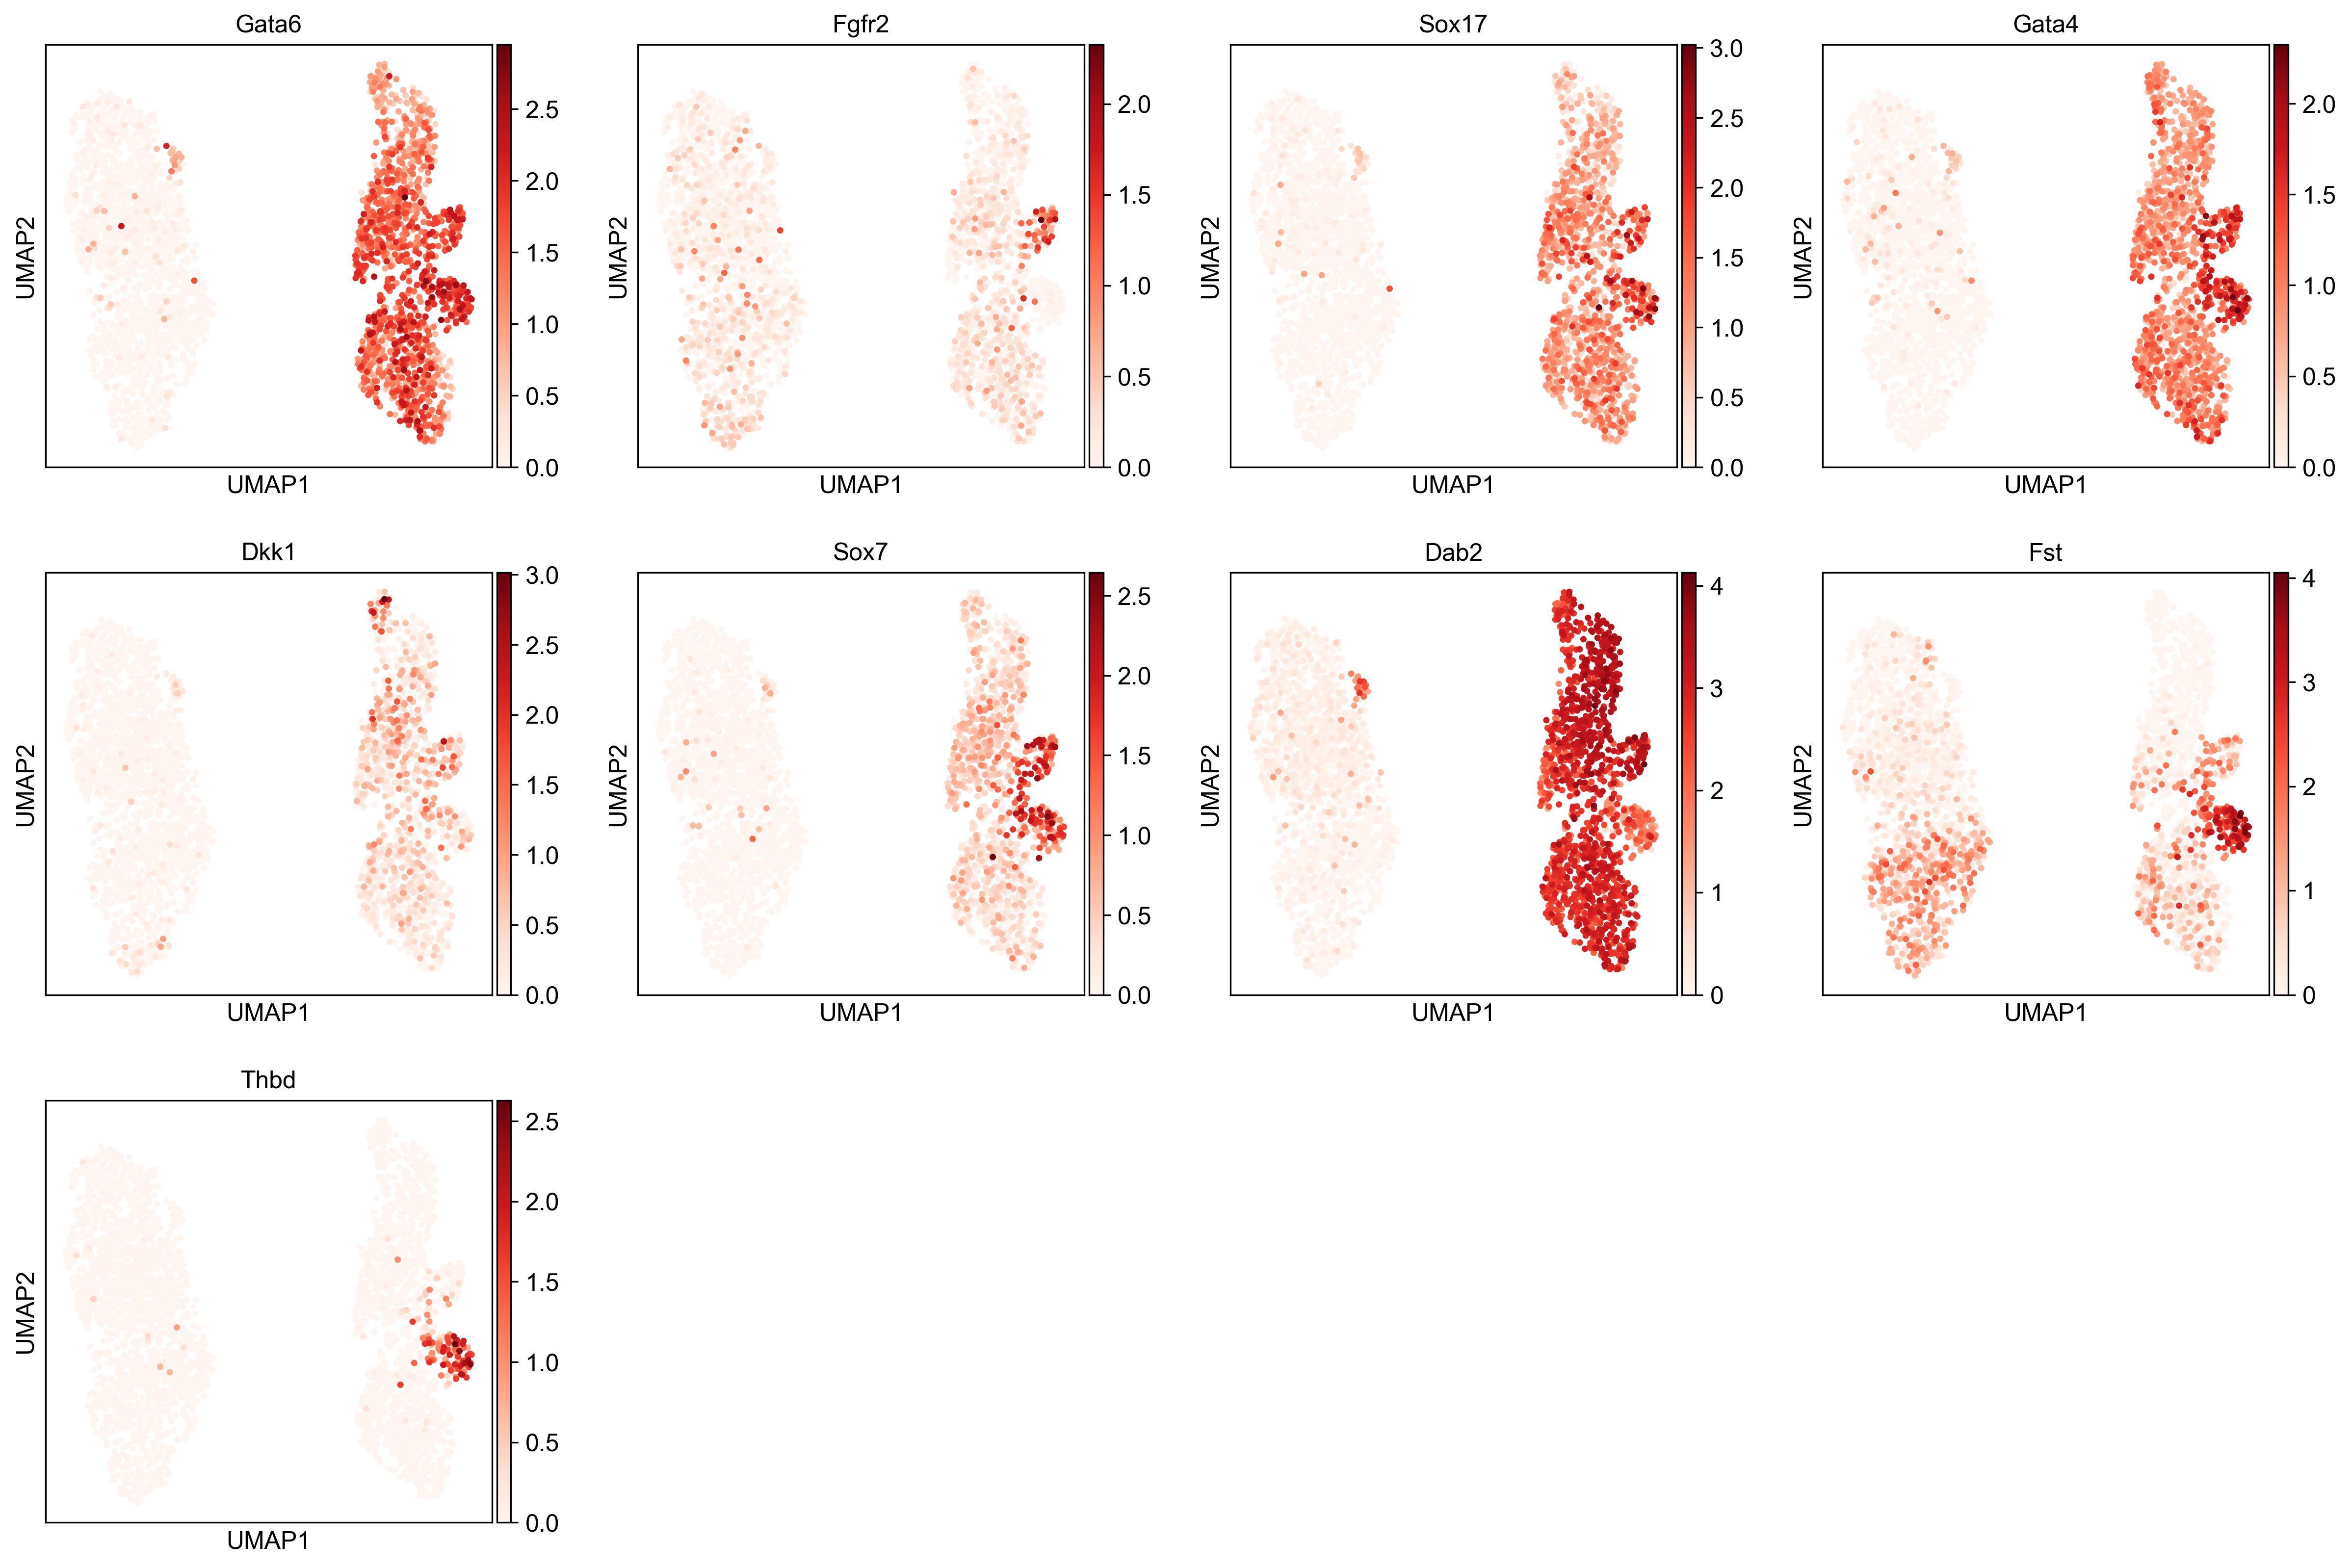

In [185]:
sc.pl.umap(adata, color=['Gata6', 'Fgfr2', 'Sox17', 'Gata4', 'Dkk1', 'Sox7', 'Dab2', 'Fst', 'Thbd'], legend_loc='on data', color_map=mpl.cm.Reds)

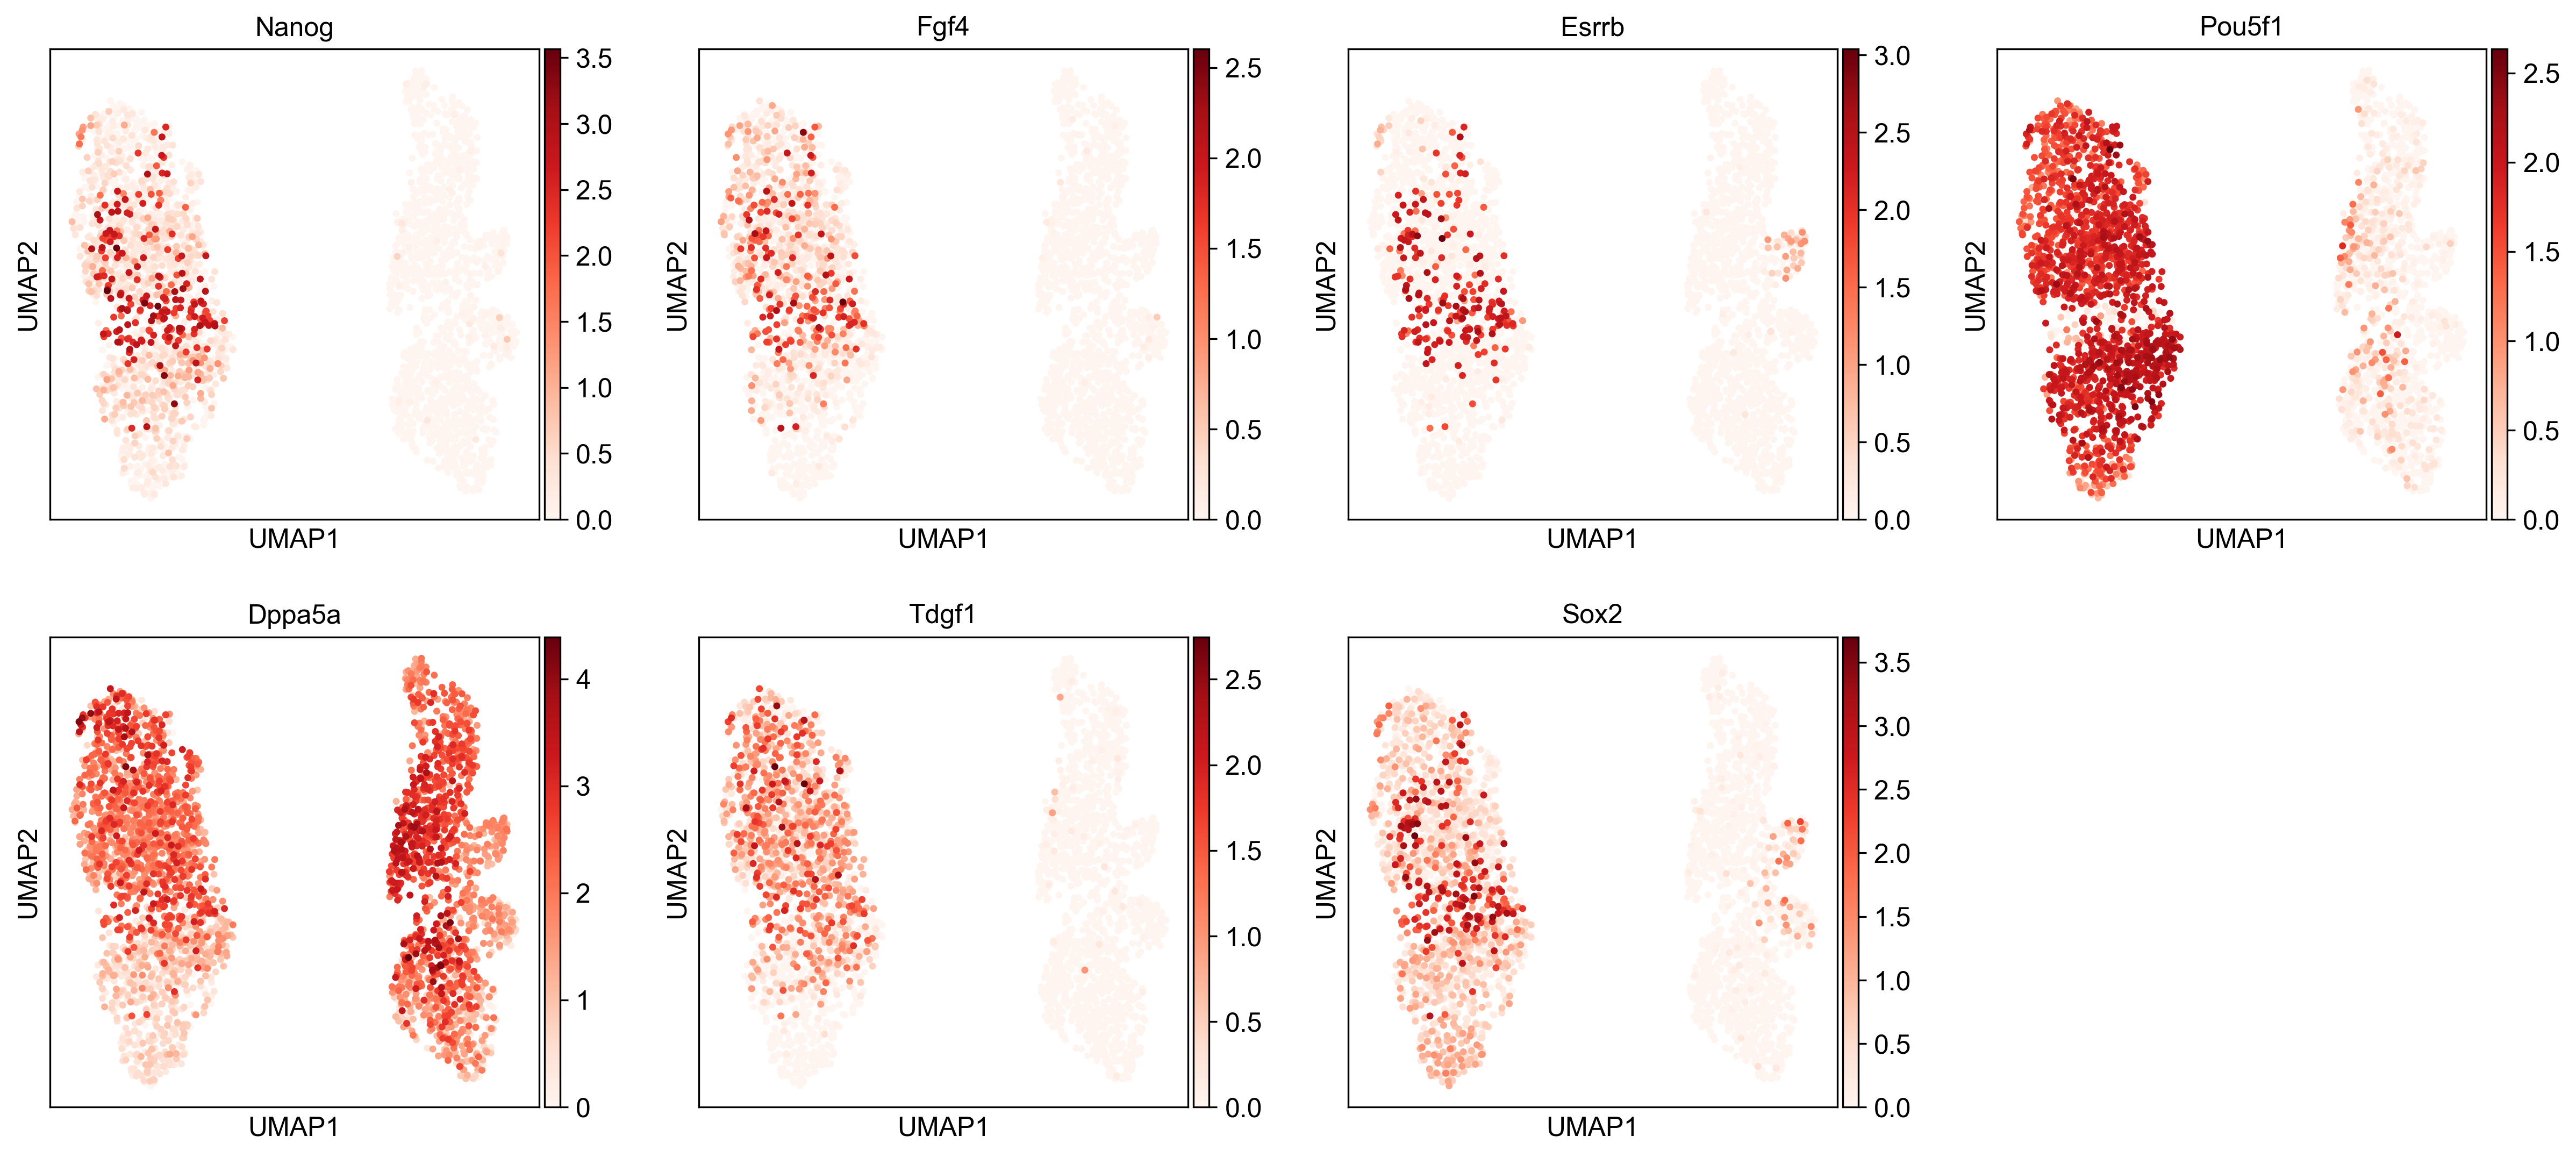

In [186]:
sc.pl.umap(adata, color=['Nanog', 'Fgf4', 'Esrrb', 'Pou5f1', 'Dppa5a', 'Tdgf1', 'Sox2'], legend_loc='on data', color_map=mpl.cm.Reds)

Looking at the markers, the 2 large clusters seem to be the PrE and the Epi. In the PrE cluster, Vrij clusteris alone and Fst is expressed so these cells would correspond to the PE. For this same marker we can see an expression but a little lighter in the Epi and we see that they are Schumacher cells. It could be another cell type or later stages and we can deduce that there is no PE in Schumacher EBs.

## **DEG analysis between Vrij PrE and Schumacher PrE** to see the differences

**Remove PE cells** thanks to Fst and Thbd markers

Take the genes

In [187]:
adata_Fst = adata[:, 'Fst']
adata_Thbd = adata[:, 'Thbd']
print(adata_Fst)
print(adata_Thbd)

View of AnnData object with n_obs × n_vars = 3082 × 1
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 3082 × 1
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


**Take cells which expressed Fst and Thbd**

In [188]:
adata_Fstpos = adata_Fst[adata_Fst.X>0]
adata_Thbdpos = adata_Thbd[adata_Thbd.X>0]
adata_Fstpos = adata_Fstpos[adata_Fstpos.obs['louvain'] != '1']
adata_Fstpos = adata_Fstpos[adata_Fstpos.obs['louvain'] != '0']
adata_Thbdpos = adata_Thbdpos[adata_Thbdpos.obs['louvain'] != '1']
adata_Thbdpos = adata_Thbdpos[adata_Thbdpos.obs['louvain'] != '0']

print(adata_Fstpos)
print(adata_Thbdpos)

View of AnnData object with n_obs × n_vars = 403 × 1
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 162 × 1
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [189]:
l_Fst = adata_Fstpos.obs_names.to_list()

In [190]:
l_Thbd = adata_Thbdpos.obs_names.to_list()

**Take cells which expressed Fst and/or Thbd**

In [191]:
l = l_Fst + l_Thbd

**Select cells from PrE without PE**

In [192]:
adata_PrE = adata[adata.obs['louvain'] != '0']
adata_PrE = adata_PrE[adata_PrE.obs['louvain'] != '1']
adata_PrE = adata_PrE[~adata_PrE.obs_names.isin(l)]

**Plot UMAPs to verify**

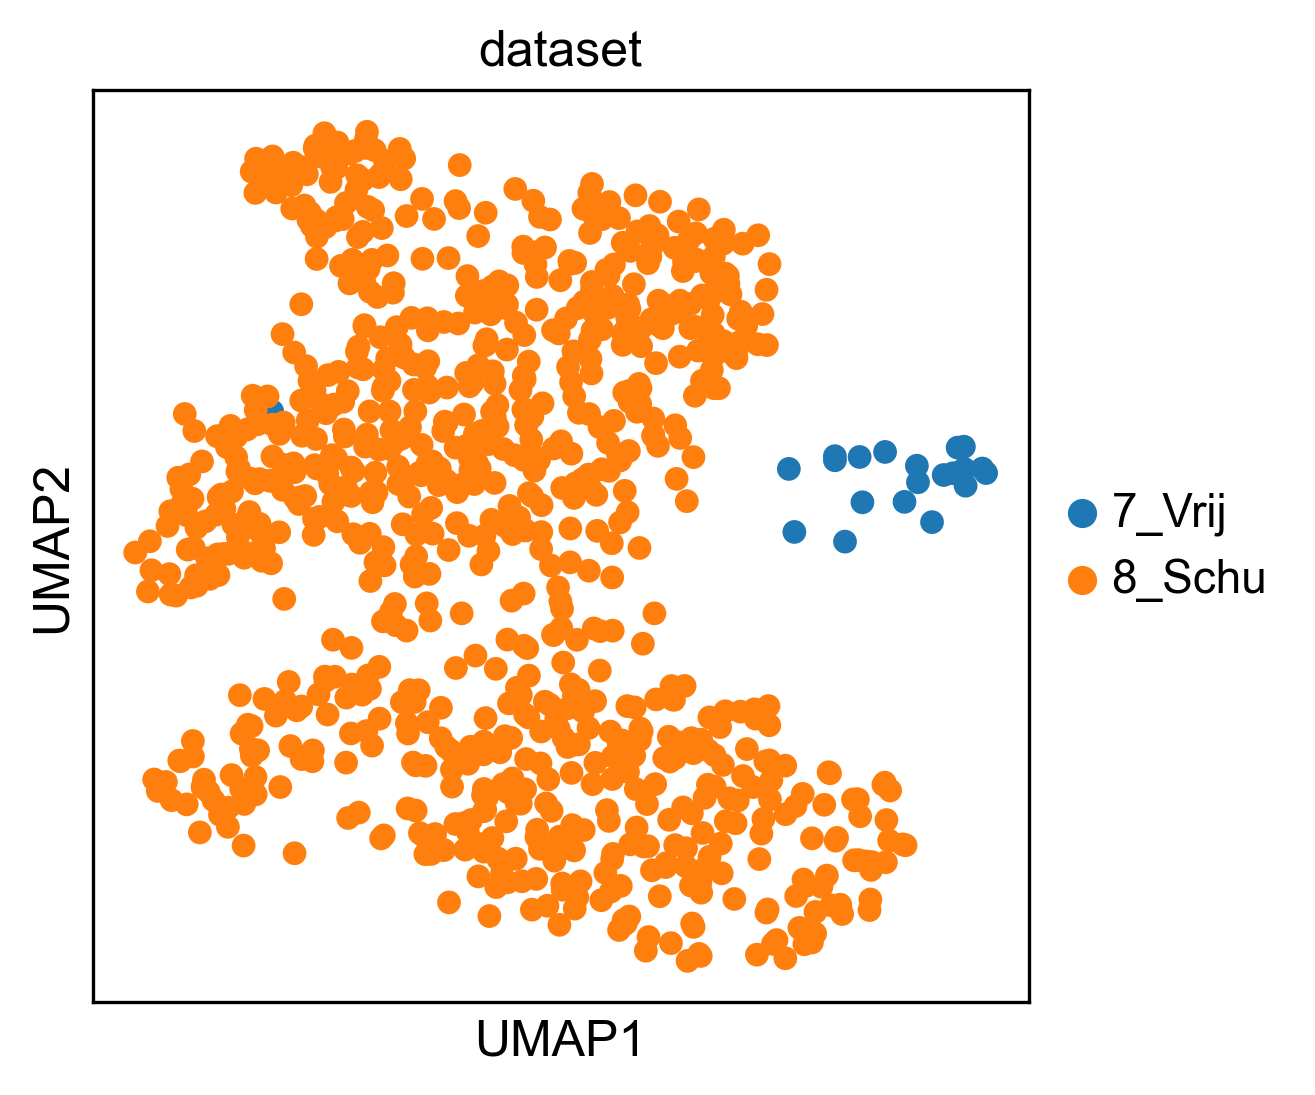

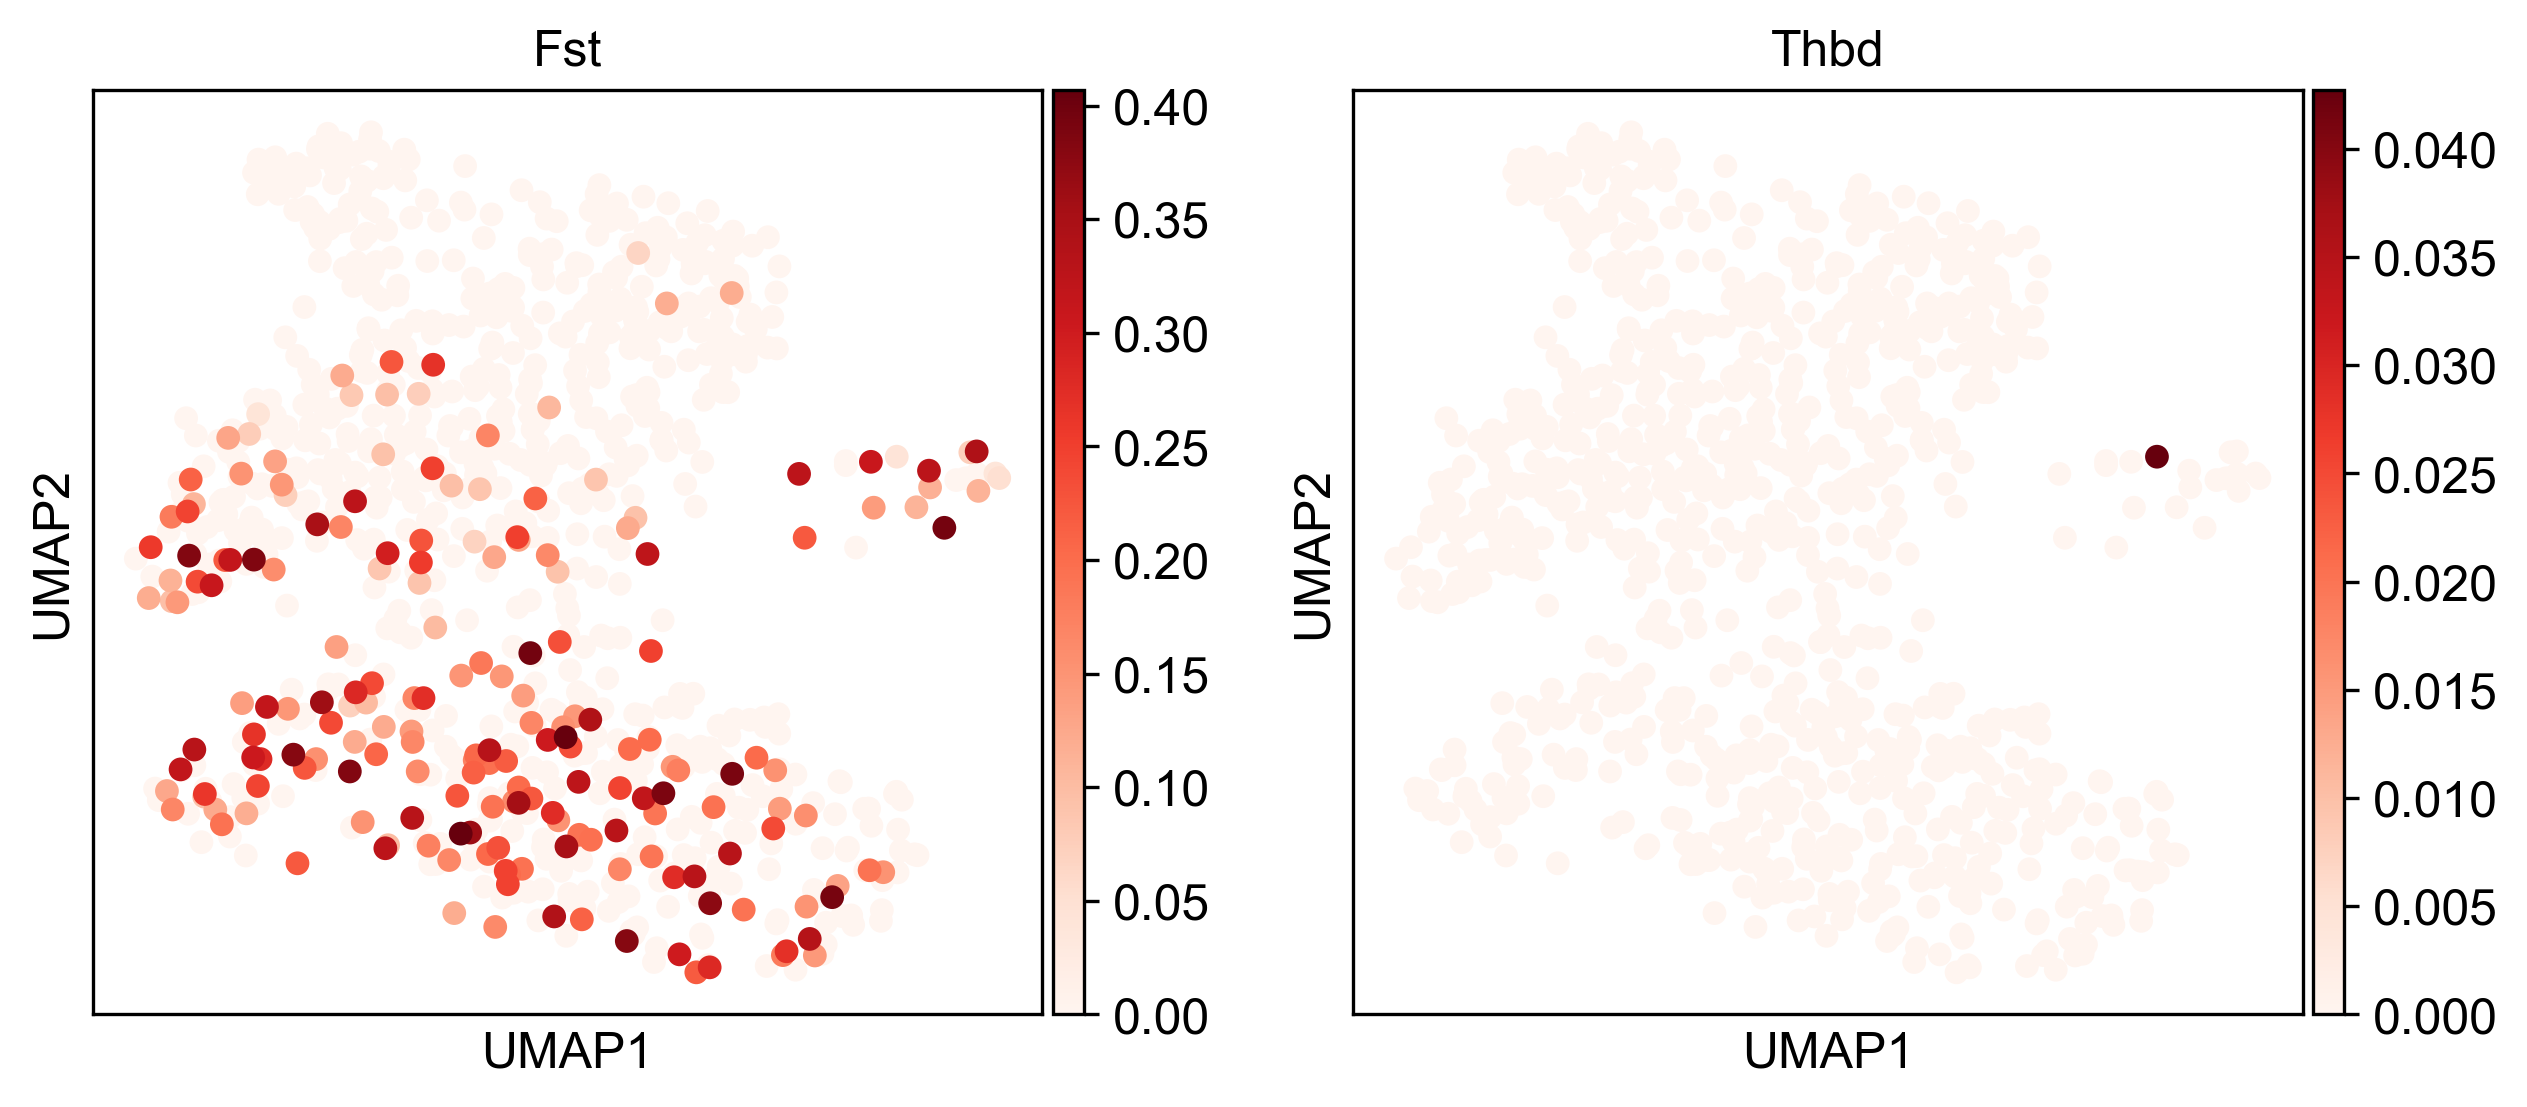

In [193]:
#sc.tl.umap(adata_PrE)
sc.pl.umap(adata_PrE, color = 'dataset')
sc.pl.umap(adata_PrE, color = ['Fst', 'Thbd'], color_map=mpl.cm.Reds)

We see that there is not much cells from Vrij, so to compare it is not very representative. I want to try to remove cells which expressed the two genes.

**Take cells which expressed Fst AND Thbd**

In [194]:
s1 = set(l_Fst)
s2 = set(l_Thbd)
l = list(s1 & s2)
print(l)

['SRR8883508', 'SRR8883561', 'SRR8883474', 'SRR8883280', 'SRR8883334', 'SRR8883511', 'SRR8883469', 'SRR8883529', 'SRR8883514', 'SRR8883276', 'AATTTCCTCCGCCTAT', 'SRR8883310', 'SRR8883526', 'SRR8883285', 'SRR8883493', 'SRR8883541', 'SRR8883327', 'SRR8883315', 'SRR8883252', 'SRR8883279', 'SRR8883569', 'SRR8883322', 'TCGAAGTGTGTCTTAG', 'SRR8883495', 'SRR8883551', 'SRR8883562', 'SRR8883567', 'SRR8883248', 'SRR8883471', 'SRR8883480', 'SRR8883256', 'SRR8883301', 'SRR8883324', 'TCTTTGAAGAGCCCAA', 'SRR8883488', 'SRR8883500', 'SRR8883521', 'SRR8883452', 'SRR8883532', 'SRR8883290', 'SRR8883275', 'SRR8883231', 'SRR8883299', 'SRR8883303', 'SRR8883512', 'SRR8883485', 'SRR8883278', 'SRR8883536', 'SRR8883306', 'SRR8883506', 'SRR8883549', 'SRR8883451', 'SRR8883445', 'SRR8883242', 'SRR8883518', 'SRR8883460', 'SRR8883277', 'SRR8883484', 'SRR8883247', 'SRR8883304', 'SRR8883590', 'SRR8883520', 'SRR8883463', 'SRR8883543', 'SRR8883539', 'SRR8883259', 'SRR8883555', 'SRR8883240', 'SRR8883458', 'SRR8883477', '

**Take PrE cells** and verify UMAPs

View of AnnData object with n_obs × n_vars = 1191 × 32673
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


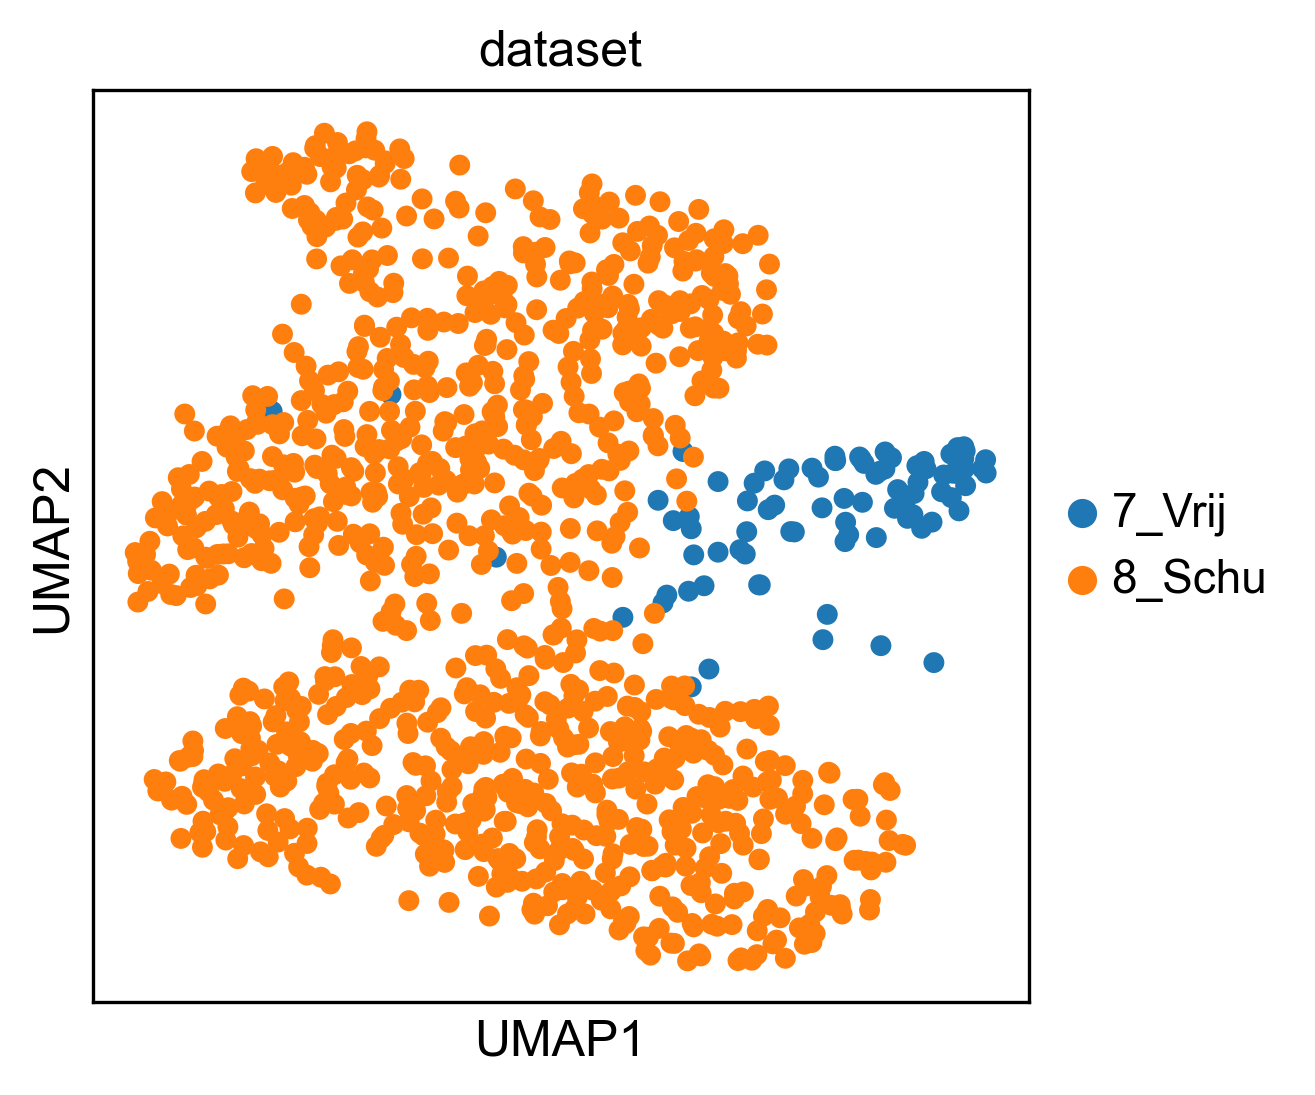

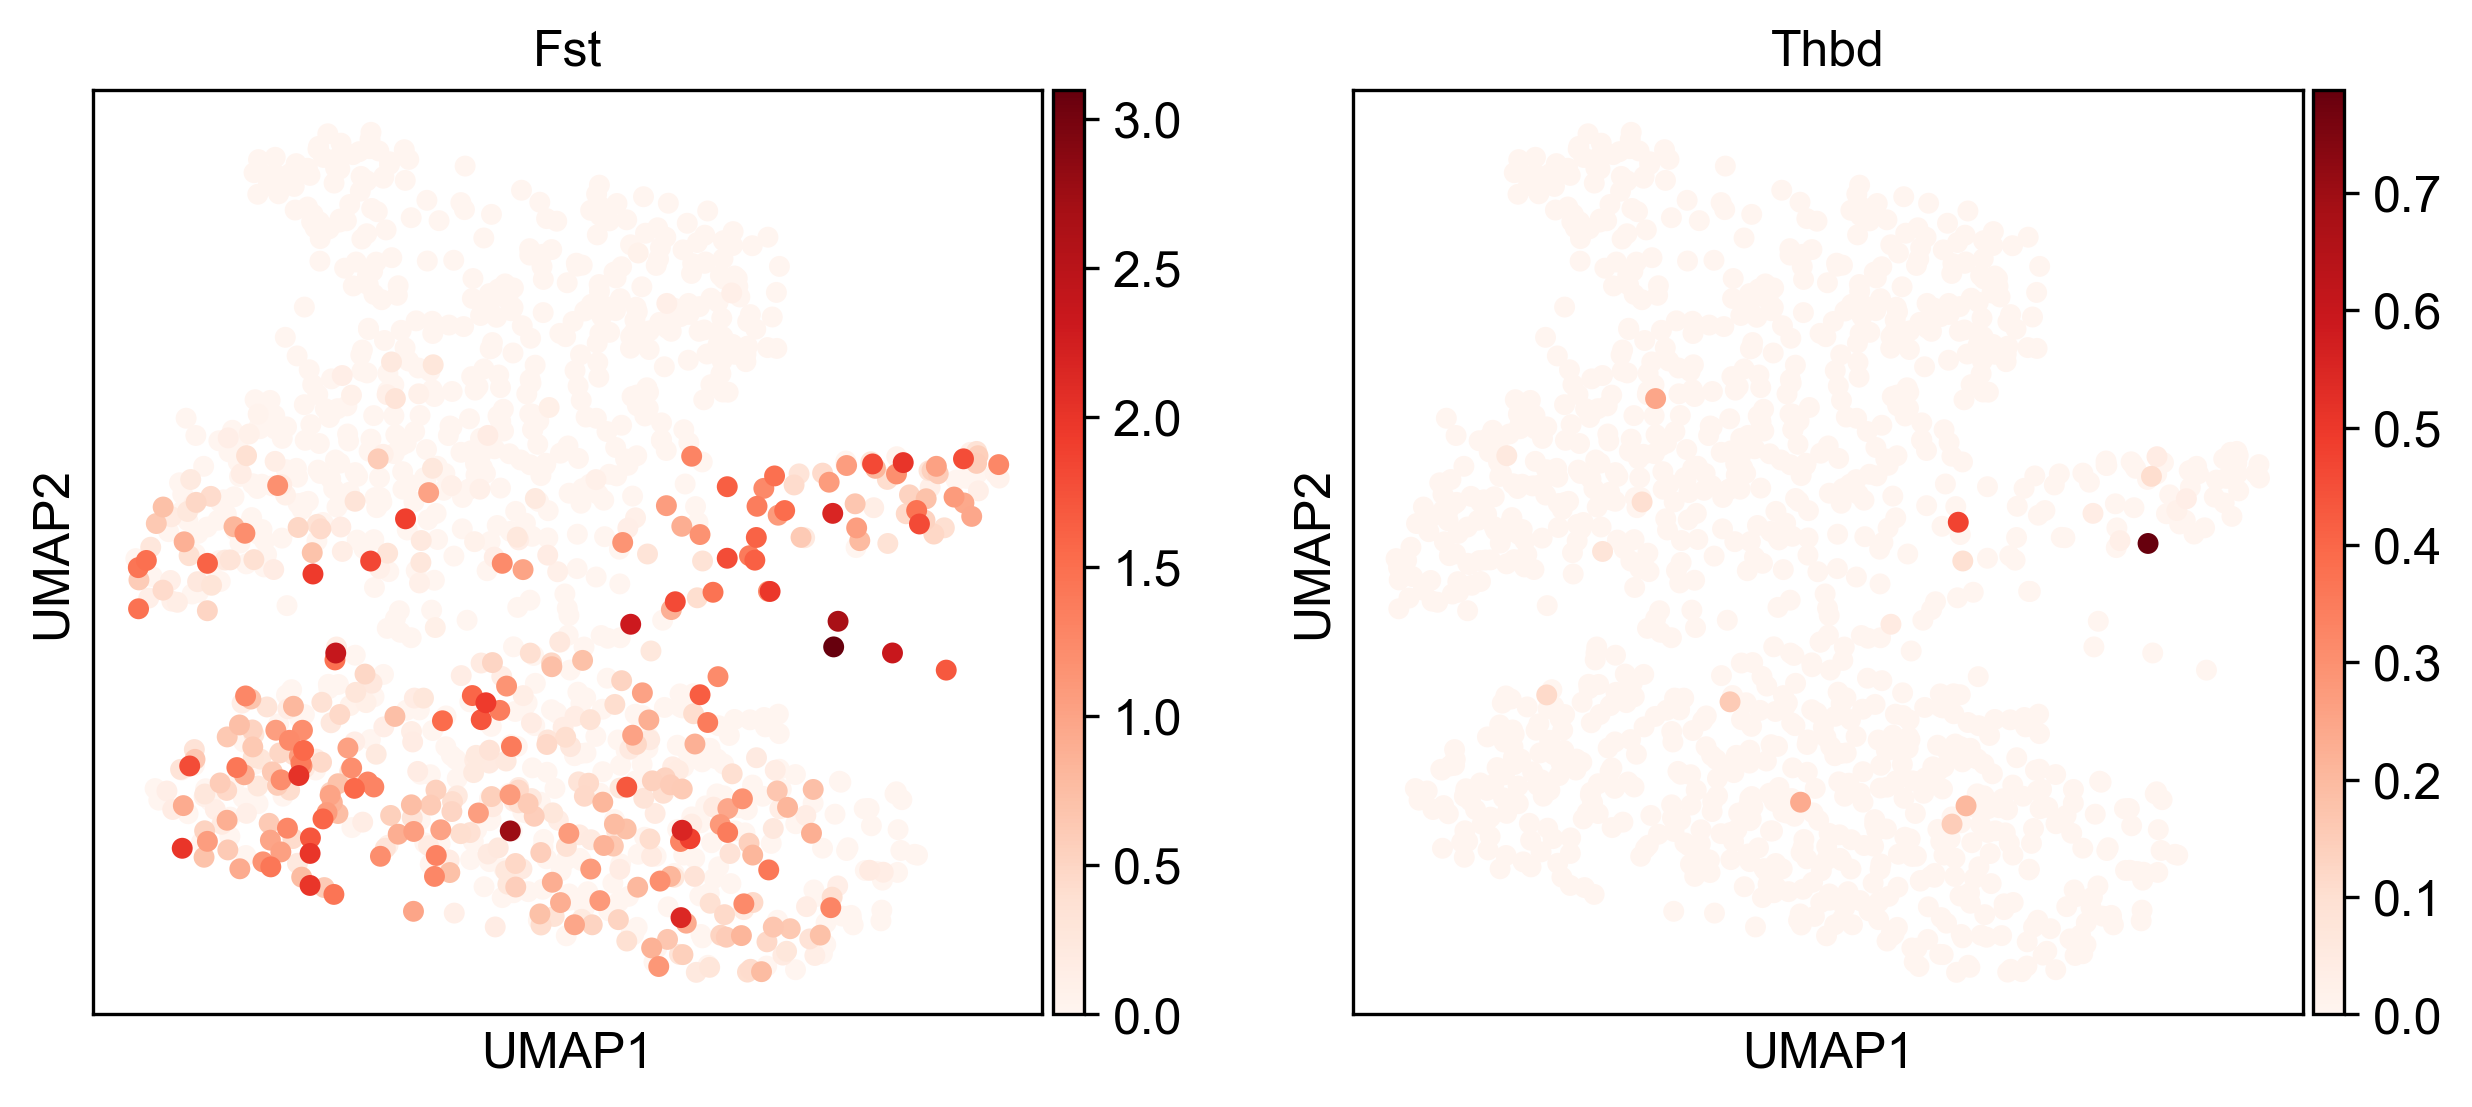

In [205]:
adata_PrE = adata[adata.obs['louvain'] != '0']
adata_PrE = adata_PrE[adata_PrE.obs['louvain'] != '1']
adata_PrE = adata_PrE[~adata_PrE.obs_names.isin(l)]
print(adata_PrE)
sc.pl.umap(adata_PrE, color = 'dataset')
sc.pl.umap(adata_PrE, color = ['Fst', 'Thbd'], color_map=mpl.cm.Reds)

We see that there is more Vrij cells but there is more cells expressed Fst. I continue analysis with this cells. 

**DEG**

In [196]:
sc.tl.rank_genes_groups(adata_PrE, 'dataset')
df = sc.get.rank_genes_groups_df(adata_PrE, group='7_Vrij')
df = df.sort_values('logfoldchanges', ascending=False)

ranking genes


C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [197]:
print(df)

         names      scores  logfoldchanges          pvals      pvals_adj
8      Gm15536   46.131317       31.341034   6.053837e-62   3.963868e-60
166    Mir6236   15.235615       30.428509   5.011495e-26   9.816582e-25
114     Gm5445   18.405336       28.931112   2.143804e-31   5.203902e-30
44      Gm5070   25.045158       28.848047   5.321583e-41   1.839916e-39
39     Gm46344   26.389116       28.806053   1.032481e-42   3.854152e-41
...        ...         ...             ...            ...            ...
32330     Rbp4  -30.532732      -30.495312  6.222650e-149  1.799227e-146
32644   mt-Co3  -94.707962      -30.730141   0.000000e+00   0.000000e+00
32576    Sycp3  -56.617004      -30.785967   0.000000e+00   0.000000e+00
32664  Gm12191 -136.927582      -30.874924   0.000000e+00   0.000000e+00
32667   mt-Co2 -147.401398      -32.248619   0.000000e+00   0.000000e+00

[32673 rows x 5 columns]


In [198]:
df.to_csv('DEG/df_comp_EB.tab', sep = '\t')

In [199]:
l_genes_XY = []
with open('DEG/gene_chrX_chrY.tab', 'r') as f:
    for lig in f:
        l_genes_XY.append(lig.rstrip())

**Remove sexual genes and Gm**

In [200]:
df = df[~df['names'].isin(l_genes_XY)]
df = df[~df['names'].str.startswith('Gm')]
filtered_df = df[df['pvals_adj'] < 0.05]

In [201]:
print(df)
print(filtered_df)

            names      scores  logfoldchanges          pvals      pvals_adj
166       Mir6236   15.235615       30.428509   5.011495e-26   9.816582e-25
1699       Il18r1    5.136436       28.155144   1.755365e-06   8.570389e-06
143    Rpl27a-ps2   16.291117       27.875967   7.095860e-28   1.508413e-26
2345       Il1rl1    4.095657       27.627600   9.564942e-05   3.643760e-04
321     Dnaja1-ps   11.732498       27.088560   1.834674e-19   2.546487e-18
...           ...         ...             ...            ...            ...
32051   Hist1h2ap  -21.898457      -29.743437   1.452749e-88   1.732324e-86
32330        Rbp4  -30.532732      -30.495312  6.222650e-149  1.799227e-146
32644      mt-Co3  -94.707962      -30.730141   0.000000e+00   0.000000e+00
32576       Sycp3  -56.617004      -30.785967   0.000000e+00   0.000000e+00
32667      mt-Co2 -147.401398      -32.248619   0.000000e+00   0.000000e+00

[20625 rows x 5 columns]
            names      scores  logfoldchanges          pvals  

In [202]:
filtered_df.to_csv('DEG/df_comp_EB_filtered.tab', sep = '\t')

In [203]:
up = filtered_df[filtered_df['logfoldchanges']>=2]
print(up)
down = filtered_df[filtered_df['logfoldchanges']<=-2]
print(down)
up.to_csv('DEG/df_comp_EB_up.tab', sep = '\t')
down.to_csv('DEG/df_comp_EB_downreg.tab', sep = '\t')

           names     scores  logfoldchanges         pvals     pvals_adj
166      Mir6236  15.235615       30.428509  5.011495e-26  9.816582e-25
1699      Il18r1   5.136436       28.155144  1.755365e-06  8.570389e-06
143   Rpl27a-ps2  16.291117       27.875967  7.095860e-28  1.508413e-26
2345      Il1rl1   4.095657       27.627600  9.564942e-05  3.643760e-04
321    Dnaja1-ps  11.732498       27.088560  1.834674e-19  2.546487e-18
...          ...        ...             ...           ...           ...
1930       Ston2   4.720711        2.005944  9.010625e-06  4.003865e-05
1606       Usp31   5.303600        2.004768  8.577253e-07  4.355005e-06
2753      Zbtb7c   3.563212        2.004062  5.981931e-04  1.999873e-03
2824    Arhgef39   3.491093        2.003315  7.605594e-04  2.494455e-03
215        Psme3  13.621807        2.000866  1.851981e-23  3.179704e-22

[733 rows x 5 columns]
           names      scores  logfoldchanges          pvals      pvals_adj
31691      Tor1a  -16.201353       -2

**Volcano plot**

C:\Users\learogue\AppData\Local\Temp\ipykernel_9628\2529538121.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)
C:\Users\learogue\AppData\Local\Temp\ipykernel_9628\2529538121.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")


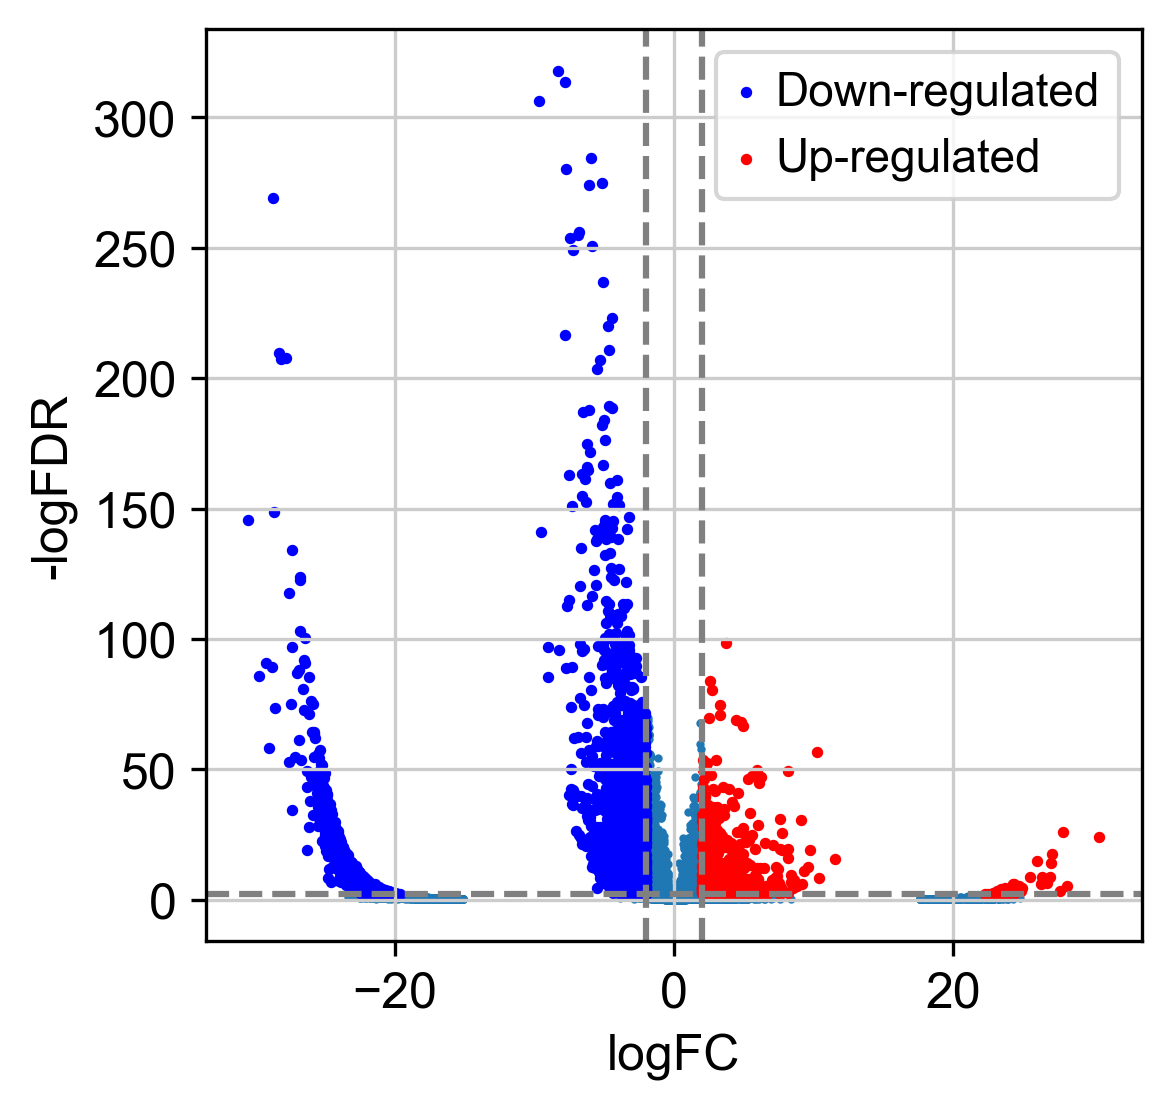

In [204]:
plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df[(df['logfoldchanges']<=-2)&(df['pvals_adj']<=0.01)]
up = df[(df['logfoldchanges']>=2)&(df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()